In [1]:
import numpy as np
import pickle

with open('cache/traintest.pkl', 'rb') as f:
    df_train, df_test, train_y = pickle.load(f)
    
with open('cache/traintest_decomposition2_50.pkl', 'rb') as f:
    out50_train, out50_test = pickle.load(f)
        
with open('cache/non_zero_stats.pkl', 'rb') as f:
    agg_train, agg_test = pickle.load(f)        

In [2]:
from sklearn.feature_selection import VarianceThreshold    
import pandas as pd
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb
import xgboost as xgb


In [3]:
df_train.shape, out50_train.shape, agg_train.shape

((4459, 4735), (4459, 100), (4459, 18))

In [4]:


def low_variance(df_train):
    s = VarianceThreshold(threshold=.0)
    s.fit(df_train)
    idxs = s.get_support()
    to_remove = [c for c, x in zip(df_train.columns, idxs) if not x]
    return to_remove

def nunique(df_train):
    _, index = np.unique(df_train.values, return_index=True, axis=1)
    return [c for idx, c in enumerate(df_train.columns) if idx not in index]

def suspicious(df_train):
    # drop zero fraction
    thr = 0.98
    to_ignore = []
    for column in df_train.columns:
        counts = df_train[column].value_counts()
        value_fraction = counts[0] / len(df_train)
        if value_fraction >= thr:
            to_ignore.append(column)
    return to_ignore



In [5]:
to_ignore = set()
to_ignore |= set(low_variance(df_train))
to_ignore |= set(nunique(df_train))
to_ignore |= set(suspicious(df_train))

In [6]:
len(to_ignore)

2614

In [7]:
features = [c for c in df_train if c not in to_ignore]

In [8]:
len(features)

2121

In [9]:
#train_X = pd.concat([df_train[features], out50_train, agg_train], axis=1)
train_X = pd.concat([out50_train, agg_train], axis=1)
train_X = train_X.replace([np.inf, -np.inf], np.nan)
train_X = train_X.fillna(0)

#test_X = pd.concat([df_test[features], out100_test, agg_test], axis=1)
test_X = pd.concat([out50_test, agg_test], axis=1)
test_X = test_X.replace([np.inf, -np.inf], np.nan)
test_X = test_X.fillna(0)


In [11]:
train_X.shape, test_X.shape

((4459, 118), (49342, 118))

In [12]:

def run_cv2(train_X, train_y):    
    params = {
        'booster': 'gbtree',
        'objective': 'reg:linear', 
        'learning_rate': 0.01,
        'max_depth': 3, 
        #'min_child_weight': 1,
        #'subsample': 0.1,
        #'colsample_bytree': 0.1,
        #'colsample_bylevel': 0.1,
        #'reg_lambda': 1,
        #'reg_alpha': 1,
        'base_score': np.mean(train_y)
    }    
    
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    hist = xgb.cv(params, 
                  xgtrain, 
                  10000, 
                  nfold=5, 
                  metrics='rmse',
                  early_stopping_rounds=100, 
                  stratified=False,
                  verbose_eval=100)


In [14]:
# run_cv2(train_X, train_y)
print('.')

.


In [15]:
def run_xgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        'booster': 'gbtree',
        'objective': 'reg:linear', 
        'learning_rate': 0.01,
        'max_depth': 3, 
        #'min_child_weight': 1,
        #'subsample': 0.1,
        #'colsample_bytree': 0.1,
        #'colsample_bylevel': 0.1,
        #'reg_lambda': 1,
        #'reg_alpha': 1,
        'base_score': np.mean(train_y)
    }
        
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    xgval = xgb.DMatrix(val_X, label=val_y)
    
    watchlist = [(xgtrain, 'train'), (xgval, 'eval')]
    
    bst = xgb.train(params, 
                    xgtrain, 
                    num_boost_round=10000, 
                    evals=watchlist,
                    early_stopping_rounds=50, 
                    verbose_eval=100)
    return bst

In [16]:
xgtest = xgb.DMatrix(test_X)
                    
folds = 3
kf = model_selection.KFold(n_splits=folds, shuffle=True, random_state=0)

sub_preds = np.zeros(test_X.shape[0])
oof_preds = np.zeros(train_X.shape[0])

for fold_no, (dev_index, val_index) in enumerate(kf.split(train_X)):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    model = run_xgb(dev_X, dev_y, val_X, val_y, test_X)
    
    xgval = xgb.DMatrix(val_X, label=val_y)
    oof_preds[val_index] = model.predict(xgval, ntree_limit=model.best_ntree_limit )
    
    fold_rmse = np.sqrt(metrics.mean_squared_error(val_y, oof_preds[val_index]))
    print(f"fold {fold_no}: ", fold_rmse)    
    
    pred_test = model.predict(xgtest, ntree_limit=model.best_ntree_limit)    
    sub_preds += np.expm1(pred_test) / folds
    
    del xgval


[0]	train-rmse:1.73733	eval-rmse:1.75875
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[100]	train-rmse:1.42313	eval-rmse:1.45822
[200]	train-rmse:1.33633	eval-rmse:1.39276
[300]	train-rmse:1.28935	eval-rmse:1.37496
[400]	train-rmse:1.2615	eval-rmse:1.36849
[500]	train-rmse:1.23889	eval-rmse:1.36332
[600]	train-rmse:1.21802	eval-rmse:1.3609
[700]	train-rmse:1.19958	eval-rmse:1.35969
[800]	train-rmse:1.18205	eval-rmse:1.35783
[900]	train-rmse:1.16572	eval-rmse:1.35647
[1000]	train-rmse:1.15063	eval-rmse:1.35541
Stopping. Best iteration:
[1046]	train-rmse:1.14397	eval-rmse:1.3552

fold 0:  1.3552011833947022
[0]	train-rmse:1.73925	eval-rmse:1.7555
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[100]	train-rmse:1.42959	eval-rmse:1.45435
[200]	train-rmse:1.34294	eval-rmse:1.38534
[300]	train-rmse:1.2

In [17]:
sample = pd.read_csv('input/test.csv', usecols=['ID'])
sample["target"] = sub_preds
sample.to_csv("submissions/subm_20180629_xgb1.csv", index=False)

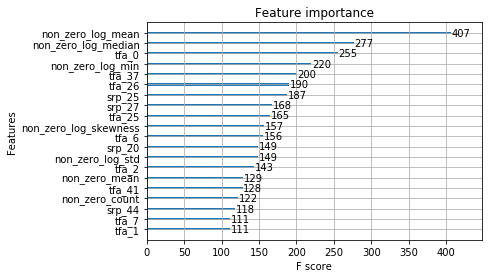

In [21]:
import matplotlib.pyplot as plt
plt.show()
xgb.plot_importance(model, max_num_features=20)